# Примеры

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## Пример 1, обучение RandomForest выявлению сепсиса

### Устройство MIMIC
В примерах разберем, как с помощью модуля sickness-screening обучить модель предсказывать сепсис на наборе данных MIMIC.
В MIMIC есть множество таблиц, но для примера нам потребуются следующие таблицы:
1. **chartevents.csv** —— содержит данные мониторинга пациентов, например: температура тела, артериальное давление.
2. **labevents.csv** —— содержит данные различных анализов пациентов, например различные характеристики анализов крови для пациентов.
3. **diagnoses.csv** —— содержит информацию о диагнозах, которые получил пациент.
4. **d_icd_diagnoses** —— расшифрофки кодов диагнозов для каждого диагноза.
5. **d_labitems.csv** —— расшифрофки кодов анализов для каждого пациента.

### Установим библиотеку

In [1]:
!pip3 install sickness-screening

#### Аггрегирование данных о диагнозах пациентов:

##### Импортирование библиотеки

In [2]:
import sickness_screening as ss

#### Аггрегирование данных о диагнозах пациентов:

In [12]:
df_gotten_diagnoses = ss.get_diagnoses_data(patient_diagnoses_csv='diagnoses.csv',
                 all_diagnoses_csv='d_icd_diagnoses.csv',
                 output_file_csv='gottenDiagnoses.csv')
print(df_gotten_diagnoses.head(10))

   subject_id                                         long_title
0    10000032                                Portal hypertension
1    10000032                                      Other ascites
2    10000032      Cirrhosis of liver without mention of alcohol
3    10000032  Unspecified viral hepatitis C without hepatic ...
4    10000032  Chronic airway obstruction, not elsewhere clas...
5    10000032                      Bipolar disorder, unspecified
6    10000032                      Posttraumatic stress disorder
7    10000032                    Personal history of tobacco use
8    10000032    Unspecified viral hepatitis C with hepatic coma
9    10000032                                      Other ascites


Здесь мы для каждого пациента из **patient_diagnoses_csv** получаем коды диагнозов, а далее, используя **all_diagnoses_csv**
мы уже получаем файл **output_file_csv** в котором для каждого пациента уже хранится расшифровка его диагноза.

#### Получение данных о том, есть ли конкретный диагноз у пациента

In [13]:
df_sepsis_info = ss.get_diseas_info(diagnoses_csv='gottenDiagnoses.csv', title_column='long_title', diseas_str='sepsis',
                    diseas_column='has_sepsis', subject_id_column='subject_id', log_stats=True,
                    output_csv='sepsis_info.csv')
print(df_sepsis_info.head(20))

Всего пациентов: 193256
Всего пациентов с сепсисом: 12616
     subject_id  has_sepsis
0      10000032       False
41     10000068       False
42     10000084       False
54     10000108       False
56     10000117       False
78     10000248       False
84     10000280       False
85     10000560       False
88     10000635       False
91     10000719       False
97     10000764       False
116    10000826       False
131    10000826        True
147    10000883       False
152    10000886       False
153    10000904       False
154    10000935       False
236    10000980       False
376    10001176       False
393    10001186       False


Здесь используем таблицу, которую мы получили из предыдущего примера, чтобы на выходе получить таблицу, в которой содержатся данные о том,
был ли у этого человека в диагнозе продстрока sepsis, или нет.

#### Аггрегирование данных, необходимых для нахождения ССВР (синдром системной воспалительной рекции)

Теперь соберем некоторые данные, необходимые для определения ССВР:

In [14]:
df_ssir = ss.get_analyzes_data(analyzes_csv='chartevents.csv', subject_id_col='subject_id', itemid_col='itemid',
                      charttime_col='charttime', value_col='value', valuenum_col='valuenum',
                      itemids=[220045, 220210, 223762, 223761, 225651], rest_columns=['Heart rate', 'Respiratory rate', 'Temperature Fahrenheit', 'Temperature Celsius',
                        'Direct Bilirubin', 'Heart rate_valueuom', 'Respiratory rate_valueuom',
                        'Temperature Fahrenheit_valueuom', 'Temperature Celsius_valueuom', 'Direct Bilirubin_valueuom'], output_csv='ssir.csv')
print(df_ssir.head(10))

   subject_id            charttime Heart rate Respiratory rate  \
0    10000032  2180-07-23 14:00:00        NaN              NaN   
1    10000032  2180-07-23 14:12:00         91               24   
2    10000032  2180-07-23 14:30:00         93               21   
3    10000032  2180-07-23 15:00:00         94               23   
4    10000032  2180-07-23 16:00:00        105               21   
5    10000032  2180-07-23 17:00:00         97               20   
6    10000032  2180-07-23 18:00:00        100               21   
7    10000032  2180-07-23 19:00:00         97               16   
8    10000032  2180-07-23 20:00:00        100               19   
9    10000032  2180-07-23 21:00:00         94               22   

  Temperature Fahrenheit Temperature Celsius Direct Bilirubin  \
0                   98.7                 NaN              NaN   
1                    NaN                 NaN              NaN   
2                    NaN                 NaN              NaN   
3            

Здесь мы используя таблицу **analyzes_csv**, **itemids**(коды анализов, которые мы хотим собрать), **rest_columns**(колонки, которые мы хотим оставить в выходной таблице),
Фунукция собирает из analyzes_csv замеры для пациентов с кодами **itemids** и записать их в **output_csv**, оставив только колонки, которые есть в **rest_columns**
В данной функции **subject_id_col** и **itemid_col** отвечают за колонки, отведенные под коды пациентов и анализов соответсвенно.
**charttime_col** отвечает за время. **valuenum_col** отвечает за колонку с единицами измерения анализов.

#### Комбинирование данных о диагнозах и ССВР

In [15]:
df_combined = ss.combine_data(first_data_csv='gottenDiagnoses.csv',
                              second_data_csv='ssir.csv',
                              output_file='diagnoses_and_ssir.csv', log_stats=False)
print(df_combined.head(10))

   subject_id            charttime  Heart rate  Respiratory rate  \
0    10000032  2180-07-23 14:00:00         NaN               NaN   
1    10000032  2180-07-23 14:12:00        91.0              24.0   
2    10000032  2180-07-23 14:30:00        93.0              21.0   
3    10000032  2180-07-23 15:00:00        94.0              23.0   
4    10000032  2180-07-23 16:00:00       105.0              21.0   
5    10000032  2180-07-23 17:00:00        97.0              20.0   
6    10000032  2180-07-23 18:00:00       100.0              21.0   
7    10000032  2180-07-23 19:00:00        97.0              16.0   
8    10000032  2180-07-23 20:00:00       100.0              19.0   
9    10000032  2180-07-23 21:00:00        94.0              22.0   

   Temperature Celsius  Direct Bilirubin has_sepsis  
0            37.055556               NaN      False  
1                  NaN               NaN      False  
2                  NaN               NaN      False  
3                  NaN             

#### Сбор и комбинирование данных об анализах крови, с данными об диагнозах и ССВР
Соберем данные об анализах крови пациентов и скомбинируем их в одну таблицу:

In [16]:
df_merged = ss.merge_and_get_data(merge_with='diagnoses_and_ssir.csv',
                      blood_csv='labevents.csv',
                      get_data_from='chartevents.csv',
                      output_csv='merged_data.csv',
                      analyzes_names = {
                        51222: "Hemoglobin",
                        51279: "Red Blood Cell",
                        51240: "Large Platelets",
                        50861: "Alanine Aminotransferase (ALT)",
                        50878: "Asparate Aminotransferase (AST)",
                        225651: "Direct Bilirubin",
                        50867: "Amylase",
                        51301: "White Blood Cells"})
print(df_merged.head(10))

/Users/artemij/miniconda3/lib/python3.12/site-packages/sickness_screening/merge_and_get_data.py:65: DtypeWarning: Columns (6) have mixed types. Specify dtype option on import or set low_memory=False.
  diagnoses_and_ssir = pd.read_csv(merge_with)


Unique patients with sepsis: 12615
Unique patients without sepsis: 163902
Patients with both sepsis and no sepsis records: 67294
Total unique patients: 243811
   subject_id            charttime Alanine Aminotransferase (ALT) Amylase  \
0    10000032  2180-03-23 11:51:00                            102     NaN   
1    10000032  2180-05-06 22:25:00                            100     NaN   
2    10000032  2180-05-07 05:05:00                             88     NaN   
3    10000032  2180-06-03 12:00:00                            110     NaN   
4    10000032  2180-06-22 11:15:00                            113     NaN   
5    10000032  2180-06-26 16:10:00                            126     NaN   
6    10000032  2180-06-27 05:10:00                            117     NaN   
7    10000032  2180-07-23 06:39:00                            153     NaN   
8    10000032  2180-07-23 14:00:00                            NaN     NaN   
9    10000032  2180-07-23 14:12:00                            NaN     N

Данная функция ищет данные об **analyzes_names** пациентов из таблиц **blood_csv.csv** и **get_data_from**,
комбинирует их вместе с **merge_with**. Стоит отметить, что эта функция также комбинирует данные о болезни каждого пациента.

#### Балансировка данных внутри каждого пациента:

In [17]:
df_balanced = ss.balance_on_patients(balancing_csv='merged_data.csv', disease_col='has_sepsis', subject_id_col='subject_id',
                        output_csv='balance.csv',
                        output_filtered_csv='balance_filtered.csv',
                        filtering_on=200,
                        number_of_patient_selected=50000,
                        log_stats=True
                        )
print(df_balanced.head(10))

/Users/artemij/miniconda3/lib/python3.12/site-packages/sickness_screening/balance_on_patients.py:29: DtypeWarning: Columns (3,6,7) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(balancing_csv)


In filtered dataset:
Unique patients with disease: 4731
Unique patients without disease: 1492
Number of lines for patients with disease: 2589267
Number of lines for patients without disease: 588962

In original dataset
Number of lines for patients with disease: 3185562
Number of lines for patients without disease: 1470456
      subject_id            charttime Alanine Aminotransferase (ALT) Amylase  \
1662    10002428  2154-08-12 12:10:00                            NaN     NaN   
1663    10002428  2154-10-18 11:00:00                             32     NaN   
1664    10002428  2155-07-14 17:50:00                            NaN     NaN   
1665    10002428  2155-07-15 08:05:00                            NaN     NaN   
1666    10002428  2155-10-17 12:45:00                            NaN     NaN   
1667    10002428  2156-04-05 13:08:00                             29      48   
1668    10002428  2156-04-12 10:20:00                             26     NaN   
1669    10002428  2156-04-12 17:25:0

#### Компрессия данных о каждом пациенте (если в наборе данных пропуски, то внутри каждого пациента пропуски заполнятся значением из этого пациента)
Теперь заполним пропуски имеющимися данными для каждого пациента, не заполняя статистическими значениями или константами:

In [3]:
df_compressed = ss.compress(df_to_compress_csv='balance.csv',
            subject_id_col='subject_id',
            output_csv='compressed_data.csv')
print(df_compressed.head(10))

/Users/artemij/miniconda3/lib/python3.12/site-packages/sickness_screening/compress.py:21: DtypeWarning: Columns (3,5,6,7) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(df_to_compress_csv)


   subject_id            charttime Alanine Aminotransferase (ALT) Amylase  \
0    10000248  2192-11-29 19:03:00                            NaN     NaN   
1    10000248  2192-11-29 23:00:00                            NaN     NaN   
2    10000248  2192-11-30 07:25:00                            NaN     NaN   
3    10000248  2192-11-30 15:25:00                            NaN     NaN   
4    10000492  2129-08-04 13:05:00                            ___     NaN   
5    10000683  2175-10-06 19:00:00                             29     NaN   
6    10000826  2146-12-05 11:30:00                             71     NaN   
7    10000826  2146-12-06 04:24:00                             56     NaN   
8    10000826  2146-12-06 09:00:00                             46     NaN   
9    10000826  2146-12-07 06:35:00                             46     NaN   

  Asparate Aminotransferase (AST) Hemoglobin Large Platelets Red Blood Cell  \
0                             NaN       10.6             NaN           3.

#### Выбрать лучших пациентов с данными для балансировки

In [21]:
df_choose = ss.choose(compressed_df_csv='compressed_data.csv',
          output_file='final_balanced_data.csv')
print(df_choose.head(10))

/Users/artemij/miniconda3/lib/python3.12/site-packages/sickness_screening/choose.py:23: DtypeWarning: Columns (3,5,6,7) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(compressed_df_csv)


    subject_id            charttime Alanine Aminotransferase (ALT) Amylase  \
6     10000826  2146-12-05 11:30:00                             71     NaN   
7     10000826  2146-12-06 04:24:00                             56     NaN   
8     10000826  2146-12-06 09:00:00                             46     NaN   
9     10000826  2146-12-07 06:35:00                             46     NaN   
10    10000826  2146-12-08 04:55:00                             46     NaN   
11    10000826  2146-12-09 04:50:00                             41     NaN   
12    10000826  2146-12-10 04:50:00                             45     NaN   
13    10000826  2146-12-11 05:00:00                             44     NaN   
14    10000826  2146-12-12 05:10:00                             33     NaN   
15    10000826  2146-12-17 09:47:00                             45     NaN   

   Asparate Aminotransferase (AST) Hemoglobin Large Platelets Red Blood Cell  \
6                              401       13.2             NaN

#### Заполнение пропущенных значений модой

In [22]:
df_filled = ss.fill_values(balanced_csv='final_balanced_data.csv',
               strategy='most_frequent',
               output_csv='filled_data.csv')
print(df_filled.head(10))

/Users/artemij/miniconda3/lib/python3.12/site-packages/sickness_screening/fill_values.py:24: DtypeWarning: Columns (3,5,6,7) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(balanced_csv)


  subject_id            charttime Alanine Aminotransferase (ALT) Amylase  \
0   10000826  2146-12-05 11:30:00                             71    49.0   
1   10000826  2146-12-06 04:24:00                             56    49.0   
2   10000826  2146-12-06 09:00:00                             46    49.0   
3   10000826  2146-12-07 06:35:00                             46    49.0   
4   10000826  2146-12-08 04:55:00                             46    49.0   
5   10000826  2146-12-09 04:50:00                             41    49.0   
6   10000826  2146-12-10 04:50:00                             45    49.0   
7   10000826  2146-12-11 05:00:00                             44    49.0   
8   10000826  2146-12-12 05:10:00                             33    49.0   
9   10000826  2146-12-17 09:47:00                             45    49.0   

  Asparate Aminotransferase (AST) Hemoglobin Large Platelets Red Blood Cell  \
0                             401       13.2               A            3.8   
1    

#### Тренировка модели на наборе данных

In [5]:
import sickness_screening as ss
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import MinMaxScaler
model = ss.train_model(df_to_train_csv='filled_data.csv',
                       categorical_col=['Large Platelets'],
                       columns_to_train_on=['Amylase','Hemoglobin', 'Red Blood Cell',  'White Blood Cells'],
                       model=RandomForestClassifier(),
                       single_cat_column='White Blood Cells',
                       has_disease_col='has_sepsis',
                       subject_id_col='subject_id',
                       valueuom_col='valueuom',
                       scaler=MinMaxScaler(),
                       random_state=42,
                       test_size=0.2)

/Users/artemij/miniconda3/lib/python3.12/site-packages/sickness_screening/train_model.py:52: DtypeWarning: Columns (8) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(df_to_train_csv)


Accuracy: 0.6798091924792186
Classification Report:
               precision    recall  f1-score   support

       False       0.39      0.30      0.34    249601
        True       0.76      0.82      0.79    665038

    accuracy                           0.68    914639
   macro avg       0.57      0.56      0.56    914639
weighted avg       0.66      0.68      0.67    914639



В этой функции мы обучаем **RandomForestClassifier** из scikit-learn на наборе данных с одной категориальной колонкой, с одной числовой колонкой
и с одной категориальной колонкой, которую можно преобразовать в числовую. В качестве метода нормализации используется **MinMaxScaler** из scikit-learn.

#### Например, можно вставить такие модели, как CatBoostClassifier или SVC с разными ядрами
CatBoostClassifier:

In [ ]:
class_weights = {0: 1, 1: 15}
clf = CatBoostClassifier(loss_function='MultiClassOneVsAll', class_weights=class_weights, iterations=50, learning_rate=0.1, depth=5)
clf.fit(X_train, y_train)

SVC с использованием гауссова ядра с радиальной базовой функцией (RBF):

In [ ]:
class_weights = {0: 1, 1: 13}
param_dist = {
    'C': reciprocal(0.1, 100),
    'gamma': reciprocal(0.01, 10),
    'kernel': ['rbf']
}

svm_model = SVC(class_weight=class_weights, random_state=42)
random_search = RandomizedSearchCV(
    svm_model,
    param_distributions=param_dist,
    n_iter=10,
    cv=5,
    scoring=make_scorer(recall_score, pos_label=1),
    n_jobs=-1
)

### Использование трансформера TabNet

Соберем датасет на основе признаков из MEWS:
*   Систолическое артериальное давление
*   Частота сердцебиения
*   Частота дыхательных движений
*   Температура

In [ ]:
item_ids = [str(x) for x in [225309, 220045, 220210, 223762]]
file_path = './MIMIC/icu/chartevents.csv'
output_path = 'df.csv'

ss.process_chartevents(file_path, output_path, item_ids)

Добавим таргет к нашему датасету - болен человек или нет

In [ ]:
drgcodes_path = './MIMIC/hosp/drgcodes.csv'
merged_data_path = './df.csv'
output_path = 'df_with_target.csv'

ss.add_diagnosis_column(drgcodes_path, merged_data_path, output_path)

Заполним пропуски

In [ ]:
input_path = 'df_with_target.csv'
output_path = 'df_with_target_imputed.csv'
features = ['225309', '220045', '220210', '223762']

ss.impute_data(input_path, output_path, features)

Разделим наш датасет на тренировочную и тестовую выборки. Затем сбалансируем тренировочный набор данных

In [ ]:
input_path = 'df_with_target_imputed.csv'
test_size = 0.4
random_state = 42
features = ['225309', '220045', '220210', '223762']
target = 'SepsisLabel'
resampled_output_path = 'train_data_MEWS.csv'
test_output_path = 'test_data.csv'

df_resampled, test_data = ss.prepare_and_save_data(input_path, test_size, random_state, features, target, resampled_output_path, test_output_path)

In [4]:
import pandas as pd

In [5]:
df = pd.read_csv('/content/drive/MyDrive/Лаба ML/transformers/train_data_MEWS.csv')

Проверим, что у нас нет дисбаланса в данных

In [6]:
print(sum(df['diagnosis'] == 0))
print(sum(df['diagnosis'] == 1))

27249
27249


Разделим тестовый набор данных на валидационную и тестовую выборки, и сбалансируем их

In [ ]:
input_path = 'test_data.csv'
test_size = 0.4
random_state = 42
features = ['225309', '220045', '220210', '223762']
target = 'diagnosis'
test_output_path = 'test_resampled_data.csv'
val_output_path = 'val_resampled_data.csv'

ss.resample_test_val_data(input_path, test_size, random_state, features, target, test_output_path, val_output_path)

Проверим, что в валидационном и тестовом наборах не дисбаланса классов

In [8]:
df = pd.read_csv('/content/drive/MyDrive/Лаба ML/transformers/val_resampled_data_MEWS.csv')

In [9]:
print(sum(df['diagnosis'] == 0))
print(sum(df['diagnosis'] == 1))

9128
9128


In [10]:
df = pd.read_csv('/content/drive/MyDrive/Лаба ML/transformers/test_resampled_data_MEWS.csv')

In [11]:
print(sum(df['diagnosis'] == 0))
print(sum(df['diagnosis'] == 1))

9065
9065


Далее обучим модель с выбранными гиперпараметрами, сохраним важность признаков

In [15]:
train_path = '/content/drive/MyDrive/Лаба ML/transformers/train_data_MEWS.csv'
val_path = '/content/drive/MyDrive/Лаба ML/transformers/val_resampled_data_MEWS.csv'
feature_importances_path = 'fimp.txt'
model_save_path = './tabnet_model_test_1'
optimizer_params = dict(lr=0.05)
scheduler_params = {
    "milestones": [10, 20, 30],
    "gamma": 0.9
}

ss.train_tabnet_model(train_path, val_path, feature_importances_path, model_save_path, optimizer_params, scheduler_params, pretraining_lr=0.05, training_lr=0.05, mask_type='sparsemax', pretraining_ratio=1.0, max_epochs=200, patience=50)

/usr/local/lib/python3.10/dist-packages/pytorch_tabnet/abstract_model.py:82: UserWarning: Device used : cpu
  warnings.warn(f"Device used : {self.device}")


epoch 0  | loss: 36.84088| val_0_unsup_loss_numpy: 3.5068378504386677e+28|  0:00:05s


/usr/local/lib/python3.10/dist-packages/pytorch_tabnet/metrics.py:59: RuntimeWarning: overflow encountered in square
  reconstruction_errors = np.multiply(errors, obf_vars) ** 2
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:118: RuntimeWarning: overflow encountered in reduce
  ret = umr_sum(arr, axis, dtype, out, keepdims, where=where)


epoch 1  | loss: 1.14778 | val_0_unsup_loss_numpy: inf     |  0:00:12s
epoch 2  | loss: 1.02261 | val_0_unsup_loss_numpy: inf     |  0:00:17s
epoch 3  | loss: 1.02943 | val_0_unsup_loss_numpy: inf     |  0:00:23s
epoch 4  | loss: 1.00712 | val_0_unsup_loss_numpy: inf     |  0:00:29s
epoch 5  | loss: 1.00862 | val_0_unsup_loss_numpy: inf     |  0:00:35s
epoch 6  | loss: 1.01511 | val_0_unsup_loss_numpy: inf     |  0:00:42s
epoch 7  | loss: 1.00804 | val_0_unsup_loss_numpy: inf     |  0:00:46s
epoch 8  | loss: 1.00626 | val_0_unsup_loss_numpy: inf     |  0:00:49s
epoch 9  | loss: 1.01127 | val_0_unsup_loss_numpy: inf     |  0:00:52s
epoch 10 | loss: 1.00864 | val_0_unsup_loss_numpy: inf     |  0:00:59s

Early stopping occurred at epoch 10 with best_epoch = 0 and best_val_0_unsup_loss_numpy = 3.5068378504386677e+28


/usr/local/lib/python3.10/dist-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
/usr/local/lib/python3.10/dist-packages/pytorch_tabnet/abstract_model.py:82: UserWarning: Device used : cpu
  warnings.warn(f"Device used : {self.device}")
/usr/local/lib/python3.10/dist-packages/pytorch_tabnet/abstract_model.py:248: UserWarning: Loading weights from unsupervised pretraining
  warnings.warn("Loading weights from unsupervised pretraining")


epoch 0  | loss: 0.68239 | val_0_auc: 0.40864 |  0:00:04s
epoch 1  | loss: 0.66268 | val_0_auc: 0.50556 |  0:00:09s
epoch 2  | loss: 0.65959 | val_0_auc: 0.54186 |  0:00:16s
epoch 3  | loss: 0.65933 | val_0_auc: 0.57439 |  0:00:19s
epoch 4  | loss: 0.65824 | val_0_auc: 0.59443 |  0:00:22s
epoch 5  | loss: 0.65685 | val_0_auc: 0.59336 |  0:00:29s
epoch 6  | loss: 0.65488 | val_0_auc: 0.5931  |  0:00:34s
epoch 7  | loss: 0.65557 | val_0_auc: 0.58179 |  0:00:40s
epoch 8  | loss: 0.653   | val_0_auc: 0.59108 |  0:00:45s
epoch 9  | loss: 0.65346 | val_0_auc: 0.58355 |  0:00:48s
epoch 10 | loss: 0.65359 | val_0_auc: 0.58407 |  0:00:50s
epoch 11 | loss: 0.6532  | val_0_auc: 0.5923  |  0:00:53s
epoch 12 | loss: 0.65292 | val_0_auc: 0.59004 |  0:00:59s
epoch 13 | loss: 0.65234 | val_0_auc: 0.58173 |  0:01:05s
epoch 14 | loss: 0.65362 | val_0_auc: 0.58971 |  0:01:10s
epoch 15 | loss: 0.65249 | val_0_auc: 0.59169 |  0:01:17s
epoch 16 | loss: 0.65185 | val_0_auc: 0.5866  |  0:01:21s
epoch 17 | los

/usr/local/lib/python3.10/dist-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)


Successfully saved model at ./tabnet_model_test_1.zip


Посмотрим на важность признаков в трансформера

In [16]:
file_path = '/content/fimp.txt'

with open(file_path, 'r') as file:
    content = file.read()
    print(content)

[0.23699013 0.32132814 0.26303686 0.17864487]


Визуализируем важность признаков

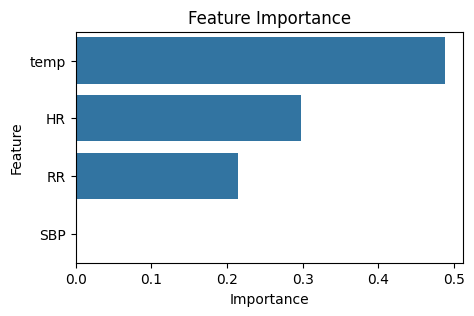

In [17]:
import matplotlib.pyplot as plt
import seaborn as sns

feature_importances = [0.0, 0.29729455, 0.21506934, 0.48763611]

importance_df = pd.DataFrame({'Feature': ['SBP','HR','RR','temp'], 'Importance': feature_importances})
importance_df = importance_df.sort_values(by='Importance', ascending=False)

plt.figure(figsize=(5, 3))
sns.barplot(data=importance_df, x='Importance', y='Feature')
plt.title('Feature Importance')
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.show()

Посмотрим метрики на тестовой выборке

In [18]:
model_path = "./tabnet_model_test_1.zip"
test_data_path = '/content/drive/MyDrive/Лаба ML/transformers/test_resampled_data_MEWS.csv'
metrics_output_path = "metrics.txt"

ss.evaluate_tabnet_model(model_path, test_data_path, metrics_output_path)

/usr/local/lib/python3.10/dist-packages/pytorch_tabnet/abstract_model.py:82: UserWarning: Device used : cpu
  warnings.warn(f"Device used : {self.device}")


In [19]:
file_path = '/content/metrics.txt'

with open(file_path, 'r') as file:
    content = file.read()
    print(content)

Accuracy: 0.5236072807501378
Precision: 0.5132115075935301
Recall: 0.9170435741864313
F1-score: 0.6581166132288327

